# setup

In [4]:
%pip install imageio
%pip install pyvirtualdisplay
%pip install tf-agents
%pip install pyglet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Imports

In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

# Seed for PPO actor network
import tensorflow_probability as tfp

# PPO Agent
from tf_agents.agents.ppo import ppo_agent
from tf_agents.agents.ppo import ppo_actor_network
from tf_agents.networks import value_network
from tf_agents.networks import actor_distribution_network
from tf_agents.agents.ppo import ppo_clip_agent


from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts


# old agent
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.networks import categorical_q_network


from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

In [6]:
env_name = "Acrobot-v1" # @param {type:"string"}

train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

observation_tensor_spec = tensor_spec.from_spec(train_env.observation_spec())
action_tensor_spec = tensor_spec.from_spec(train_env.action_spec())
time_step_tensor_spec = tensor_spec.from_spec(train_env.time_step_spec())

In [7]:
print('Observation: {0}'.format(observation_tensor_spec))
print('Action: {0}'.format(action_tensor_spec))
print('TimeStep: {0}'.format(time_step_tensor_spec))

Observation: BoundedTensorSpec(shape=(6,), dtype=tf.float32, name='observation', minimum=array([ -1.      ,  -1.      ,  -1.      ,  -1.      , -12.566371,
       -28.274334], dtype=float32), maximum=array([ 1.      ,  1.      ,  1.      ,  1.      , 12.566371, 28.274334],
      dtype=float32))
Action: BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(2))
TimeStep: TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': BoundedTensorSpec(shape=(6,), dtype=tf.float32, name='observation', minimum=array([ -1.      ,  -1.      ,  -1.      ,  -1.      , -12.566371,
       -28.274334], dtype=float32), maximum=array([ 1.      ,  1.      ,  1.      ,  1.      , 12.566371, 28.274334],
      dtype=float32)),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

# Agent

Network

In [8]:
# actor_fc_layers = (128,64,32,16,8,4,2)
# value_fc_layers = (128,64,32,16,8,4,2)
actor_fc_layers = (64,64)
value_fc_layers = (64,64)

actor_net = actor_distribution_network.ActorDistributionNetwork(
        observation_tensor_spec,
        action_tensor_spec,
        fc_layer_params=actor_fc_layers,
        activation_fn=tf.nn.tanh,
        kernel_initializer=tf.keras.initializers.Orthogonal(seed=1),
        # seed_stream_class=DeterministicSeedStream,
        seed_stream_class=tfp.util.SeedStream
)

value_net = value_network.ValueNetwork(
    observation_tensor_spec,
    fc_layer_params=value_fc_layers,
    kernel_initializer=tf.keras.initializers.Orthogonal()
)

In [9]:
learning_rate = 3e-4 
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent_ppo = ppo_agent.PPOAgent(
    time_step_spec=time_step_tensor_spec,
    action_spec=action_tensor_spec,
    actor_net=actor_net,
    value_net=value_net,
    optimizer=optimizer,
    train_step_counter=train_step_counter,
    # compute_value_and_advantage_in_train=True,
    # update_normalizers_in_train=False,
    num_epochs=10
)
agent_ppo.initialize()

2022-09-27 22:51:18.252057: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
num_eval_episodes= 10

def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return
  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

random_policy = random_tf_policy.RandomTFPolicy(
   time_step_tensor_spec,
    action_tensor_spec,
    info_spec=time_step_tensor_spec)

def evaluate_policy(policy):
  for _ in range(1):
    avg= compute_avg_return(eval_env, policy, num_eval_episodes)
    print(avg)

evaluate_policy(random_policy)

evaluate_policy(agent_ppo.policy)

evaluate_policy(agent_ppo.collect_policy)


-484.4
-500.0
-500.0


In [11]:
batch_size = 128
replay_buffer_size = 10000
replay_buffer_batch_size = 1

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    agent_ppo.collect_policy.trajectory_spec,
    batch_size=replay_buffer_batch_size,
    max_length=replay_buffer_size
)

In [12]:

def collect_step(environment, policy):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)
    replay_buffer.add_batch(traj)
    # print(next_time_step.reward)


In [13]:
initial_collect_steps = 1000

for _ in range(initial_collect_steps):
    collect_step(train_env, agent_ppo.collect_policy)

In [14]:
n_step_update = 1
# batch_size = 64

dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, sample_batch_size=batch_size,
    num_steps=n_step_update + 1).prefetch(batch_size)

iterator = iter(dataset)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [15]:
num_iterations = 10000
num_eval_episodes = 10
eval_interval = int(num_iterations/10)
log_interval = eval_interval * 10
collect_steps_per_iteration = 10

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent_ppo.train = common.function(agent_ppo.train)
agent_ppo.train_step_counter.assign(0)

avg_return = compute_avg_return(eval_env, agent_ppo.policy, num_eval_episodes)
returns = [avg_return]
returns

for _ in range(num_iterations):
  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, agent_ppo.collect_policy)
  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent_ppo.train(experience).loss

  step = agent_ppo.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent_ppo.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1:2f}'.format(step, avg_return))
    returns.append(avg_return)


step = 1000: Average Return = -500.000000
step = 2000: Average Return = -500.000000
step = 3000: Average Return = -500.000000
step = 4000: Average Return = -500.000000
step = 5000: Average Return = -500.000000
step = 6000: Average Return = -500.000000
step = 7000: Average Return = -500.000000
step = 8000: Average Return = -500.000000
step = 9000: Average Return = -500.000000
step = 10000: loss = 55.593971252441406
step = 10000: Average Return = -500.000000
step = 11000: Average Return = -500.000000
step = 12000: Average Return = -500.000000
step = 13000: Average Return = -500.000000
step = 14000: Average Return = -500.000000
step = 15000: Average Return = -500.000000
step = 16000: Average Return = -500.000000
step = 17000: Average Return = -500.000000
step = 18000: Average Return = -500.000000
step = 19000: Average Return = -500.000000
step = 20000: loss = 24.8603515625
step = 20000: Average Return = -500.000000
step = 21000: Average Return = -500.000000
step = 22000: Average Return = 

(-527.5, 550.0)

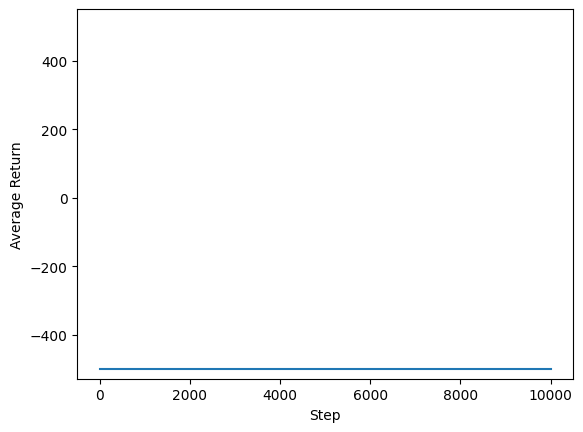

In [20]:
steps = range(0, num_iterations + 1, 100)
# steps = range(0, num_iterations + 1, 10)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim(top=550)

In [ ]:
train_env._action_spec.

SyntaxError: invalid syntax (1417812230.py, line 1)